# Grover's Algorithm
Consider a solution for finding an item in an unsorted array. Without any structure, it seems like the best solution would be to simply search through elements of the array until the desired element is found. Given an array of size N, this would take on average, N/2 lookups. However, through the power of quantum computing the time complexity can be reduced to $O(\sqrt{n})$.

## The naive classical solution:
We simply loop over the elements until we find the desired element

In [160]:
my_list = [1, 3, 5, 2, 4, 9, 5, 8, 0, 7, 6]

In [161]:
def the_oracle(my_input):
    winner = 7
    return my_input == winner

In [162]:
for index, trial_number in enumerate(my_list):
    if the_oracle(trial_number):
        print(f"Found the winner at index {index}!")
        print(f"{index+1} calls made")
        break

Found the winner at index 9!
10 calls made


## The new ***QUANTUM*** solution

**Grover's algorithm** can be broken down like so:
- Initialize the state
- Isolate the desired state(s)
- Amplify the desired state(s)
- Repeat isolation and Amplification at most $O(\sqrt{n})$ times

In [163]:
from qiskit import *
from qiskit.visualization import plot_histogram, array_to_latex
from qiskit.providers.ibmq import least_busy
import matplotlib.pyplot as plt
import numpy as np

## Simple Scenario: 2 qubits
We will "search" for the quantum state $\ket{11}$
In reality we wouldn't know what we're searching for beforehand, but this is practice!

In [164]:
grover_circuit = QuantumCircuit(2)

# Initialization
To begin Grover's algorithm, we first initialize the circuit with the state $\ket{s}$ which is equal to the state $\frac{1}{\sqrt{N}}\ket{11...1}$, if we were to measure this now, it would just randomly pick a state with equal probability.

In [165]:
def init_state(qc, qubits):
    for q in qubits:
        qc.h(q)
    return qc

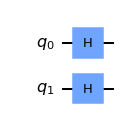

In [166]:
grover_circuit = init_state(grover_circuit, [0, 1])
grover_circuit.draw("mpl")

## The Oracle
We must first isolate the required quantum state using our oracle.
The oracle will flip the desired state while leaving the others the same.
Our current implementation of the oracle may seem like cheating, we've basically coded in our solution of $\ket{11}$, however, this circuit does still perform Grover's algorithm like a real one would. In practice, the oracle would be more complex. If we go back to the example of searching through an unsorted array, it could check if the element at a certain index is equal to the one we're searching for. It could also do weirder things like checking if a given sudoku solution is correct.

In [167]:
#define the oracle circuit
def oracle(qc, qubits):
    qc.cz(qubits[0], qubits[1])

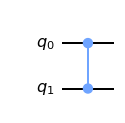

In [168]:
qc = QuantumCircuit(2)
oracle(qc, [0, 1])
qc.draw("mpl")

This oracle simply takes the state $\ket{11}$ to $-\ket{11}$.
This can be verified by looking at the matrix conversion below.

In [169]:
usim = Aer.get_backend('aer_simulator')
qc.save_unitary()
qobj = assemble(qc)
unitary = usim.run(qobj).result().get_unitary()

array_to_latex(unitary, prefix="\\text{One can see that only the state }\ket{11}\\text{ has been flipped: }\n")

<IPython.core.display.Latex object>

## The Diffusion Operator:
Once the desired result has been isolated from the others, it must be amplified to ensure that the circuit can measure it.

More information about the diffuser(with diagrams can be found on my full post about Quantum Teleportation here: )

In [170]:
def diffusion(qc, qubits):
    qc.h([0, 1])

    qc.z([0, 1])
    qc.cz(0, 1)

    qc.h([0, 1])

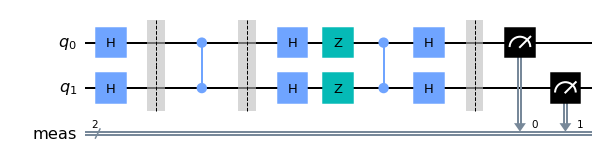

In [171]:
grover_circuit.barrier()
oracle(grover_circuit, [0, 1])
grover_circuit.barrier()
diffusion(grover_circuit, [0, 1])
grover_circuit.measure_all()
grover_circuit.draw("mpl")

## Testing
Now we have to see if this all actually works or if I'm just a liar!

In [172]:
# Let's see if the final statevector matches our expectations
sv_sim = Aer.get_backend('statevector_simulator')
result = sv_sim.run(grover_circuit).result()
statevec = result.get_statevector()
statevec

Statevector([-0.+0.0000000e+00j,  0.+0.0000000e+00j,  0.+0.0000000e+00j,
              1.-2.4492936e-16j],
            dims=(2, 2))


In [173]:
aer_sim = Aer.get_backend('aer_simulator')
result = execute(grover_circuit, aer_sim, shots=1024).result()
result.get_counts()

{'11': 1024}

In [174]:
# Load IBM Q account and get the least busy backend device
# Run the following line with your API token to use IBM's own quantum computers
#IBMQ.save_account('')
provider = IBMQ.load_account()
provider = IBMQ.get_provider("ibm-q")
device = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 3 and 
                                   not x.configuration().simulator and x.status().operational==True))
print("Running on current least busy device: ", device)

Running on current least busy device:  ibmq_lima


In [175]:
# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
from qiskit.tools.monitor import job_monitor
transpiled_grover_circuit = transpile(grover_circuit, device, optimization_level=3)
job = device.run(transpiled_grover_circuit)
job_monitor(job, interval=2)

Job Status: job has successfully run


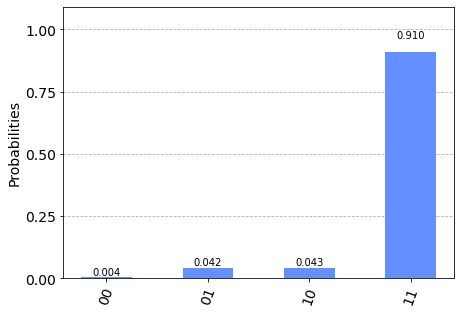

In [176]:
# Get the results from the computation
results = job.result()
answer = results.get_counts(grover_circuit)
plot_histogram(answer)

## Now that we've got the basics down with a 2 qubit system, how does it generalize?

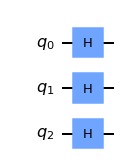

In [177]:
grover_circuit = QuantumCircuit(3)
grover_circuit = init_state(grover_circuit, [0, 1, 2])
grover_circuit.draw("mpl")

## Our three qubit oracle will mark both the states $\ket{101}$ and $\ket{110}$

In [178]:
oracle_qc = QuantumCircuit(3)
oracle_qc.cz(0, 1)
oracle_qc.cz(0, 2)
oracle_gate = oracle_qc.to_gate()   
oracle_gate.name = "U$_\omega$"

## We now create a new diffusion operator which will generalize to larger systems!

In [179]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> -> |11..1>
    for qubit in range(nqubits):
        qc.h(qubit)
        qc.x(qubit)

    # When these are combined, they function as a multi-controlled Z gate
    # A negative phase is added to |11..1> to flip the state
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)

    # Apply transformation |11..1> -> |00..0> -> |s>
    for qubit in range(nqubits):
        qc.x(qubit)
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s

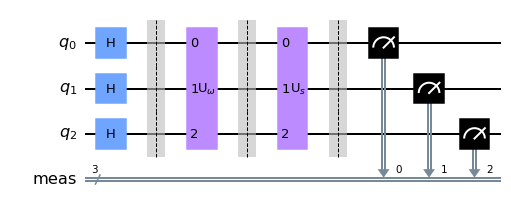

In [180]:
num_qubits = 3
grover_circuit = QuantumCircuit(num_qubits)
grover_circuit = init_state(grover_circuit, [0, 1, 2])
grover_circuit.barrier()
grover_circuit.append(oracle_gate, [0, 1, 2])
grover_circuit.barrier()
grover_circuit.append(diffuser(num_qubits), [0, 1, 2])
grover_circuit.measure_all()
grover_circuit.draw("mpl")

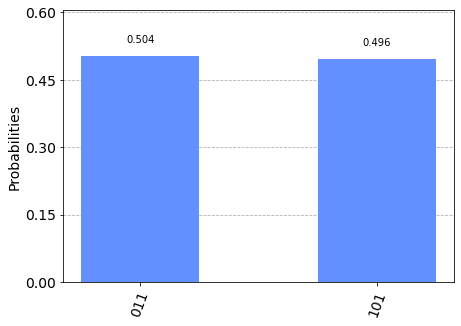

In [181]:
qasm_sim = Aer.get_backend('qasm_simulator')
transpiled_grover_circuit = transpile(grover_circuit, qasm_sim)
results = qasm_sim.run(transpiled_grover_circuit).result()
counts = results.get_counts()
plot_histogram(counts)

In [182]:
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 3 and 
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

least busy backend:  ibmq_lima


In [183]:
# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
from qiskit.tools.monitor import job_monitor
transpiled_grover_circuit = transpile(grover_circuit, device, optimization_level=3)
job = device.run(transpiled_grover_circuit)
job_monitor(job, interval=2)

Job Status: job has successfully run


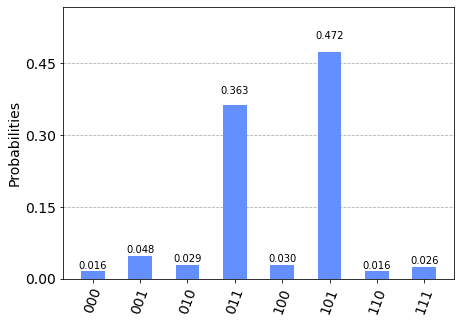

In [184]:
# Get the results from the computation
results = job.result()
answer = results.get_counts(grover_circuit)
plot_histogram(answer)